In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from lcm import LCM
%matplotlib inline

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'serif','serif':['Times New Roman']})
figSize  = (12, 6)
fontSize = 20

The aim of this tutorial is to provide a label 0 (bogus) or real (1) to each candidate ID or candidate file. In astronomy, the candidate file is simply an image that contains either a source (labelled as real) or bogus (contains noise).

For supervised learning, we need to construct a large training set with label. We had 10 volunteers to label each candidate file. This means that for each candidate we will have 10 labels. Given that the volunteers independently labelled the files, 7 voulunteers might label a particular candidate file as 0 and 3 of them might labelled the same candidate file as 1. 

For example, the question one might ask: which label will we assign to a candidate if 5 volunteer label it as real and the other 5 volunteer labelled it as bogus? This is where latent class model can be helpful.

The aim is to assign each candidate file a label and incorporate the uncertainties of the volunteer's labels in the final label. Let's first analyse the data.

# Load data
Data should be in the format
- rows: Number of images
- columns: Volunteers vote as either real (1) or bogus (0)

In [2]:
data_ori = pd.read_csv('10_volunteers_voting_5000.csv')
data_ori.head()

,transientid,volunteer_1,volunteer_2,volunteer_3,volunteer_4,volunteer_5,volunteer_6,volunteer_7,volunteer_8,volunteer_9,volunteer_10
0,510,0,0,0,0,0,0,0,0,0,0
1,607,0,0,0,0,0,0,0,0,0,1
2,707,0,0,0,0,0,0,0,0,0,0
3,725,0,0,0,0,0,0,0,0,0,0
4,5233,1,1,1,1,1,1,1,1,1,1


In [3]:
#remove transientId and turn dataframe into an array
data = data_ori.iloc[:,1:]
data = np.array(data)
data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 0, 0],
       [1, 1, 1, ..., 1, 0, 0]])

The next step is to understand how latent class model works. In this tutorial we have use materials from this [link](https://static1.squarespace.com/static/5a970ef5372b96ff61c13d3b/t/5a9aee0b71c10b1a7d1400f3/1520102924040/math_4840_project_final.pdf).

<img src="./figures/LCM_1.png">

<img src="./figures/LCM_2.png">

<img src="./figures/LCM_5.png">

<img src="./figures/LCM_6.png">


# Apply LCM algorithm
The LCM is implemented in lcm.py. Please refer to the equations above to understand the coding in lcm.py.
We use <b>n_class=2</b> as we are dealing with binary classification. In this case, we use max_iteration = 20 as the EM algorithm converges quite quickly. That is, we achieve a maximum-log-likelihood at around 10 ietrations.

In [4]:
lcm_model = LCM(n_class=2, tol=10e-5, max_iter=20, verbose=1, random_state=1234)

### Fit the lcm model to the data

In [5]:
lcm_model.fit(data)

Maximization step with EM algorithm starting
	EM step 0
	EM step 1
	EM step 2
	EM step 3
	EM step 4
	EM step 5
	EM step 6
	EM step 7


### Plot the maximum log-likelihood with number of iterations using EM algorithm

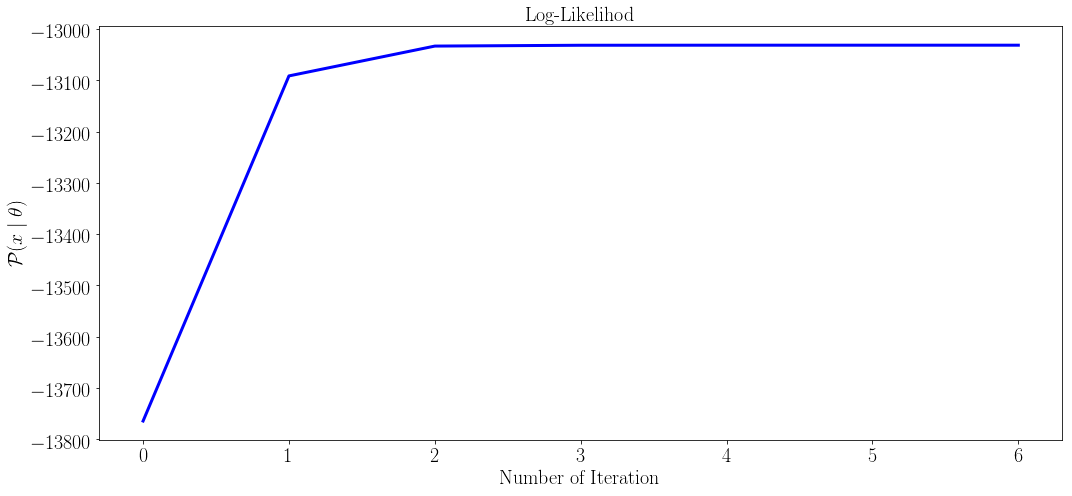

In [6]:
plt.figure(figsize=(15,7))
plt.plot(lcm_model.log_likeld_[1:], linewidth=3, color='b')
plt.title("Log-Likelihod", fontsize=fontSize)
plt.xlabel("Number of Iteration", fontsize=fontSize)
plt.ylabel(r"$\mathcal{P}(x\mid\theta$)", fontsize=fontSize)
plt.tick_params(axis='both', labelsize=fontSize)
plt.tight_layout()

### Model parameters

In [7]:
# get the parameters beta (see Equation 5(i)) as follows
lcm_model.beta

array([0.47117838, 0.52882162])

In [8]:
# get the parameters beta (see Equation 5(ii)) as follows
lcm_model.theta

array([[0.01615971, 0.04715776, 0.04134277, 0.13474516, 0.1109761 ,
        0.06899923, 0.02775151, 0.03089399, 0.00400664, 0.00517872],
       [0.96665089, 0.98630665, 0.9835456 , 0.97747704, 0.97029024,
        0.98008294, 0.96388662, 0.93990752, 0.76833499, 0.8062452 ]])

In [9]:
#compute the bic of the model
lcm_model.calculate_bic(data)

26182.423069075125

# Prediction 
Predict the final label of the candidate files based on the volunteers labelling

In [10]:
# Predict the class as either 0(bogus) or 1 (real)
predict_class = lcm_model.predict(data)
predict_class

array([0, 0, 0, ..., 0, 1, 1])

In [11]:
# The probability of it being bogus or real
predict_class_proba = lcm_model.predict_proba(data)
predict_class_proba

array([[1.00000000e+00, 1.82215056e-14],
       [1.00000000e+00, 1.45653591e-11],
       [1.00000000e+00, 1.82215056e-14],
       ...,
       [1.00000000e+00, 1.82215056e-14],
       [4.60875326e-07, 9.99999539e-01],
       [6.94129014e-10, 9.99999999e-01]])

## Merge the final label from LCM to the original table. 
This table can be used for supervised learning approach - where each candidate file is assigned a label by LCM model instead of taking the maximum probability vote.

In [12]:
data_ori['label'] = predict_class

In [13]:
data_ori.iloc[0:20,:]

,transientid,volunteer_1,volunteer_2,volunteer_3,volunteer_4,volunteer_5,volunteer_6,volunteer_7,volunteer_8,volunteer_9,volunteer_10,label
0,510,0,0,0,0,0,0,0,0,0,0,0
1,607,0,0,0,0,0,0,0,0,0,1,0
2,707,0,0,0,0,0,0,0,0,0,0,0
3,725,0,0,0,0,0,0,0,0,0,0,0
4,5233,1,1,1,1,1,1,1,1,1,1,1
5,5236,0,0,0,0,0,0,0,0,0,0,0
6,5402,1,1,1,1,1,1,1,1,1,1,1
7,5408,1,1,1,1,1,0,0,1,0,1,1
8,5490,0,1,1,0,1,1,1,1,0,1,1
9,5574,1,1,1,1,1,1,1,1,1,1,1


In [14]:
data_ori.to_csv('LCA_voting_5000.csv', index=None)
data_ori.to_excel('LCA_voting_5000.xlsx', index=None)

# Use BIC values to check how many class labels is/are appropriate to fit the data
In our context, since we already know that we had only 2 classes, we there use n_class = 2. However, in case this is not known since the begining, we use BIC to select the best model. Preferred models are those that minimize values of the BIC.

In [15]:
n_classes = [2, 3, 4, 5, 6, 7]
bics = []
for n in n_classes:
    lcm_model = LCM(n_class=n, tol=10e-4, max_iter=1000, verbose=1, random_state=1234)
    lcm_model.fit(data)
    bics.append(lcm_model.calculate_bic(data))

Maximization step with EM algorithm starting
	EM step 0
	EM step 1
	EM step 2
	EM step 3
	EM step 4
	EM step 5
	EM step 6
Maximization step with EM algorithm starting
	EM step 0
	EM step 1
	EM step 2
	EM step 3
	EM step 4
	EM step 5
	EM step 6
	EM step 7
	EM step 8
	EM step 9
	EM step 10
	EM step 11
	EM step 12
	EM step 13
	EM step 14
	EM step 15
	EM step 16
	EM step 17
	EM step 18
	EM step 19
	EM step 20
	EM step 21
	EM step 22
	EM step 23
	EM step 24
	EM step 25
	EM step 26
	EM step 27
	EM step 28
	EM step 29
	EM step 30
	EM step 31
	EM step 32
	EM step 33
	EM step 34
	EM step 35
	EM step 36
	EM step 37
	EM step 38
	EM step 39
	EM step 40
	EM step 41
	EM step 42
	EM step 43
	EM step 44
	EM step 45
Maximization step with EM algorithm starting
	EM step 0
	EM step 1
	EM step 2
	EM step 3
	EM step 4
	EM step 5
	EM step 6
	EM step 7
	EM step 8
	EM step 9
	EM step 10
	EM step 11
	EM step 12
	EM step 13
	EM step 14
	EM step 15
	EM step 16
	EM step 17
	EM step 18
	EM step 19
	EM step 20
	EM 

	EM step 390
	EM step 391
	EM step 392
	EM step 393
	EM step 394
	EM step 395
	EM step 396
	EM step 397
	EM step 398
	EM step 399
	EM step 400
	EM step 401
	EM step 402
	EM step 403
	EM step 404
	EM step 405
	EM step 406
	EM step 407
	EM step 408
	EM step 409
	EM step 410
	EM step 411
	EM step 412
	EM step 413
	EM step 414
	EM step 415
	EM step 416
	EM step 417
	EM step 418
	EM step 419
	EM step 420
	EM step 421
	EM step 422
	EM step 423
	EM step 424
	EM step 425
	EM step 426
	EM step 427
	EM step 428
	EM step 429
	EM step 430
	EM step 431
	EM step 432
	EM step 433
	EM step 434
	EM step 435
	EM step 436
	EM step 437
	EM step 438
	EM step 439
	EM step 440
	EM step 441
	EM step 442
	EM step 443
	EM step 444
	EM step 445
	EM step 446
	EM step 447
	EM step 448
	EM step 449
	EM step 450
	EM step 451
	EM step 452
	EM step 453
	EM step 454
	EM step 455
	EM step 456
	EM step 457
	EM step 458
	EM step 459
	EM step 460
	EM step 461
	EM step 462
	EM step 463
	EM step 464
	EM step 465
	EM step 466

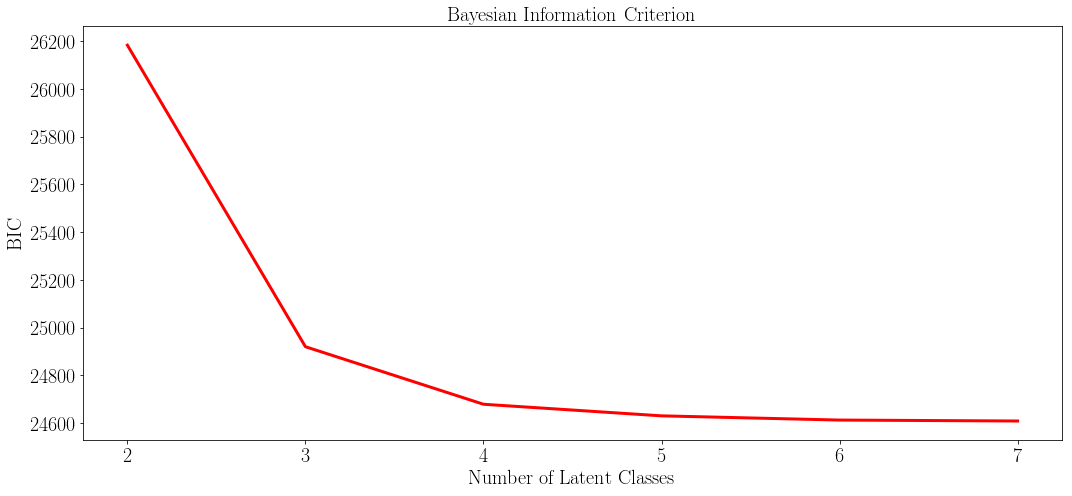

In [16]:
plt.figure(figsize=(15,7))
plt.plot(n_classes, bics, linewidth=3, color='r')
plt.title("Bayesian Information Criterion", fontsize=fontSize)
plt.xlabel("Number of Latent Classes", fontsize=fontSize)
plt.ylabel(r"BIC", fontsize=fontSize)
plt.tick_params(axis='both', labelsize=fontSize)
plt.tight_layout()